## 数据处理

In [1]:
import pandas as pd
import datetime
import calendar

### 数据展示

In [15]:
rf=pd.read_csv('SHIBOR1月.csv')
odata = pd.read_csv('上证50etf期权2015年.csv')
edata = pd.read_csv('15年ETF.csv')
test = edata

In [16]:
test.head()

,date,ETF_price
0,2015-12-31,2.275
1,2015-12-30,2.282
2,2015-12-29,2.290
3,2015-12-28,2.271
4,2015-12-25,2.341


In [17]:
odata.head()

,日期,交易代码,行权价,期权简称,收盘价,结算价,code
0,2015-12-31,510050C1603M02650,2.65,50ETF购2016年3月2.65,0.0499,0.0499,1603
1,2015-12-31,510050C1603M02700,2.70,50ETF购2016年3月2.70,0.0409,0.0409,1603
2,2015-12-31,510050C1603M02750,2.75,50ETF购2016年3月2.75,0.0330,0.0330,1603
3,2015-12-31,510050C1603M02800,2.80,50ETF购2016年3月2.80,0.0280,0.0269,1603
4,2015-12-31,510050C1603M02850,2.85,50ETF购2016年3月2.85,0.0216,0.0216,1603


In [20]:
rf.head()

,代码,名称,日期,价格
0,SHIBOR1M.IR,SHIBOR1月,2006-10-08,2.5319
1,SHIBOR1M.IR,SHIBOR1月,2006-10-09,2.5522
2,SHIBOR1M.IR,SHIBOR1月,2006-10-10,2.5739
3,SHIBOR1M.IR,SHIBOR1月,2006-10-11,2.5864
4,SHIBOR1M.IR,SHIBOR1月,2006-10-12,2.5900


### 处理数据

In [5]:
#找到当前时刻上证50ETF对应的平价期权
def find_atm_strike_price(temp,i):
    strike_prices = temp['行权价'].tolist()
    xxx = [abs(item-test['ETF_price'][i]) for item in strike_prices]
    index = xxx.index(min(xxx))
    best_strike_price = temp['行权价'].tolist()[index]
    return best_strike_price

#计算剩余期限
def get_maturity_month(i):
    date = test['date'].tolist()[i]
    ddate = datetime.datetime.strptime(date,'%Y-%m-%d')
    now_month = ddate.month
    if now_month==12:
        return '1'
    else:
        return str(now_month+1)
    
#寻找下月第四个礼拜三作为到期日
def cal_next_month_ForthWed(i):
    date = total['日期'].tolist()[i]
    ddate = datetime.datetime.strptime(date,'%Y-%m-%d')
    now_year = ddate.year
    now_month = ddate.month
    d = 1
    if now_month==12:
        next_month=1
        now_year=now_year+1
    else:
        next_month=now_month+1
    while(calendar.weekday(now_year,next_month,d)!=2):
        d+=1
    aim_date = datetime.date(now_year,next_month,d+21)
    return datetime.datetime.strftime(aim_date,"%Y-%m-%d")

#total内包含当前etf的结算价、行权价、剩余期限、无风险利率
total=pd.DataFrame()
for i in range(len(test)):
    try:
        temp=odata[odata['日期'].isin([test['date'][i]])]
        temp_list = []
        for j in range(len(temp)):
            temp_year = temp['期权简称'].tolist()[j].split('年')
            temp_month= temp_year[-1].split('月')[0]
            maturity_month = get_maturity_month(i)

            if temp_month==maturity_month:
                temp_list.append(j)
        temp = temp.iloc[temp_list,:]
        strike_price = find_atm_strike_price(temp,i)
        aim_option = temp[temp['行权价'].isin([strike_price])]
        total=total.append(aim_option)
    except Exception:
        pass
total['ETF_price']=[test[test['date'].isin([item])]['ETF_price'].tolist()[0] for item in total['日期'].tolist()]
total['Next_Month_ForthWed']=[cal_next_month_ForthWed(i) for i in range(len(total))]
total['Time_to_Maturity']=[((datetime.datetime.strptime(total['Next_Month_ForthWed'].tolist()[i],'%Y-%m-%d')-(datetime.datetime.strptime(total['日期'].tolist()[i],'%Y-%m-%d'))).days)/365 for i in range(len(total))]
total['rf']=total['日期'].apply(lambda x:rf[rf['日期']==x]['价格'].tolist()[0]/100)

### 处理结果

In [6]:
total.head()

,日期,交易代码,行权价,期权简称,收盘价,结算价,code,ETF_price,Next_Month_ForthWed,Time_to_Maturity,rf
79,2015-12-31,510050C1601M02250,2.25,50ETF购2016年1月2.25,0.1769,0.1769,1601,2.275,2016-01-27,0.073973,0.03002
82,2015-12-31,510050P1601M02250,2.25,50ETF沽2016年1月2.25,0.0144,0.0144,1601,2.275,2016-01-27,0.073973,0.03002
180,2015-12-30,510050C1601M02300,2.30,50ETF购2016年1月2.30,0.1441,0.1441,1601,2.282,2016-01-27,0.076712,0.03004
183,2015-12-30,510050P1601M02300,2.30,50ETF沽2016年1月2.30,0.0201,0.0205,1601,2.282,2016-01-27,0.076712,0.03004
280,2015-12-29,510050C1601M02300,2.30,50ETF购2016年1月2.30,0.1489,0.1489,1601,2.290,2016-01-27,0.079452,0.03005


## 计算隐含波动率

In [9]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

### 计算

In [21]:
#对每一天循环
date=total['日期'].unique().tolist()
#存储隐含波动率数据
vol_list=[]
for j in range(len(date)):
    sample=total[total['日期']==date[j]]
    #寻找每天对应的看涨期权信息
    call_sample=sample[sample['期权简称'].apply(lambda x:True if '购' in x else False)==True]
    #如果某天不止一支看涨期权的话循环处理
    temp=[]
    for i in range(len(call_sample)):
        x=call_sample.iloc[i,:]
        s=x['ETF_price'];
        k=x['行权价'];
        rf=x['rf'];
        t=x['Time_to_Maturity']
        c=x['结算价']
        def bsm_pricing(vol):
            d1=(np.log(s/k)+(rf+vol**2/2)*t)/(vol*np.sqrt(t))
            d2=d1-vol*np.sqrt(t)
            price=s*scipy.stats.norm.cdf(d1)-k*scipy.stats.norm.cdf(d2)*np.exp(-rf*t)
            error=price-c
            return error
        implied_vol=fsolve(bsm_pricing,0)
        temp.append(implied_vol[0])
    vol_list.append(np.mean(temp))

g:\python\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


### 展示

In [22]:
df=pd.DataFrame()
df['IV']=vol_list
df['date']=date
df=df.sort_values(by='date')

Text(0.5,1,'SSE50 Option Implied Voltility')

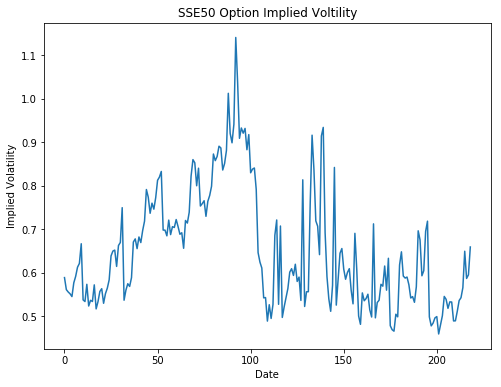

In [23]:
fig=plt.figure(figsize=(8,6))
plt.plot(df['IV'].tolist())
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('SSE50 Option Implied Voltility')